In [1]:
%load_ext autoreload
%autoreload 2
# Get paths of training data
import glob
from pathlib import Path
import pyedflib
from hmpai.pytorch.generators import MultiNumpyDataset, worker_init_fn
from hmpai.pytorch.pretraining import random_masking
import pandas as pd
import numpy as np
import multiprocessing
import os
from tqdm.notebook import tqdm
import pickle
from hmpai.pytorch.models import *
from hmpai.pytorch.training import train_and_test, pretrain
from sklearn.model_selection import train_test_split
import itertools
import h5py
DATA_PATH = Path(os.getenv("DATA_PATH"))

### Create split_edf_files

In [2]:
# Optional, if split_edf_files.txt does not exist yet
path = Path("../../data/tueg_split")

files = path.glob("*.h5")

with open('split_edf_files.txt', 'w') as file:
    for f_name in files:
        file.write(str(f_name) + "\n")

### Load split_edf_files

In [2]:
# Assumes files are already gathered in split_edf_files.txt
with open('split_edf_files.txt', 'r') as file:
    files = file.readlines()
files = [file.rstrip('\n') for file in files]
# files = files[:100]

### Create index map

In [4]:
gen = MultiNumpyDataset(data_paths=files)

In [5]:
# Save gen.index_map to file
gen.index_map.to_csv('index_map.csv', index=False)

In [6]:
index_map = pd.read_csv('index_map.csv')

### Load index map

In [3]:
index_map = pd.read_csv('index_map.csv')
# index_map = gen.index_map
idx_train, idx_val = train_test_split(index_map, test_size=0.2, random_state=42)
idx_train = idx_train.reset_index(drop=True)
idx_val = idx_val.reset_index(drop=True)
train_data = MultiNumpyDataset(data_paths=files, index_map=idx_train)
val_data = MultiNumpyDataset(data_paths=files, index_map=idx_val)

In [4]:
file = h5py.File(files[0])

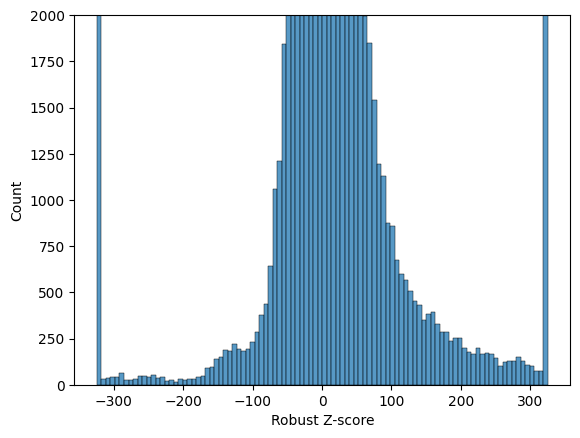

-323.85147 325.00986 0.018183067 9.096432


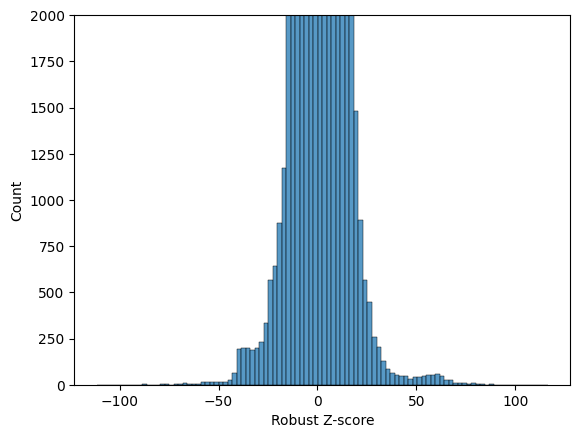

-111.46 116.52 -0.030408747 2.389574


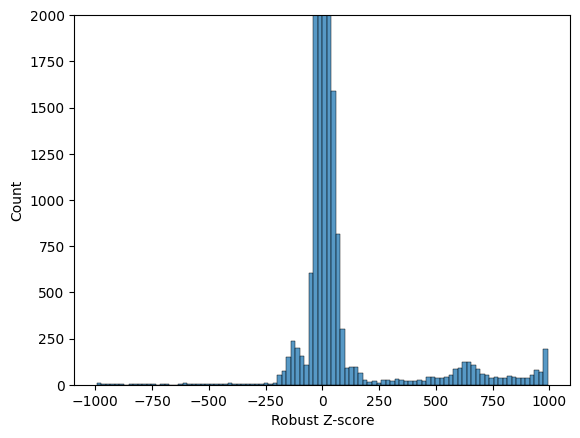

-993.0 992.90906 0.18583891 13.564419


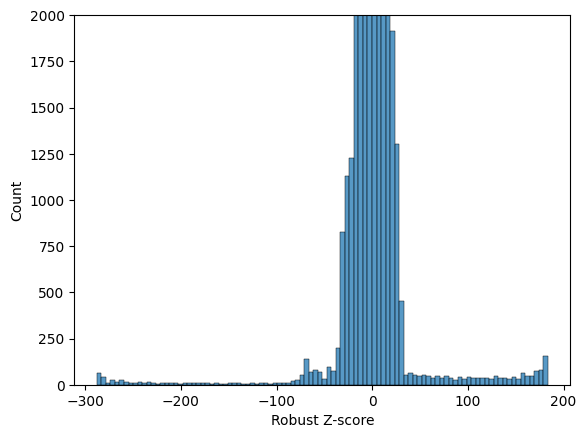

-287.82455 183.54385 0.049445193 3.7110054


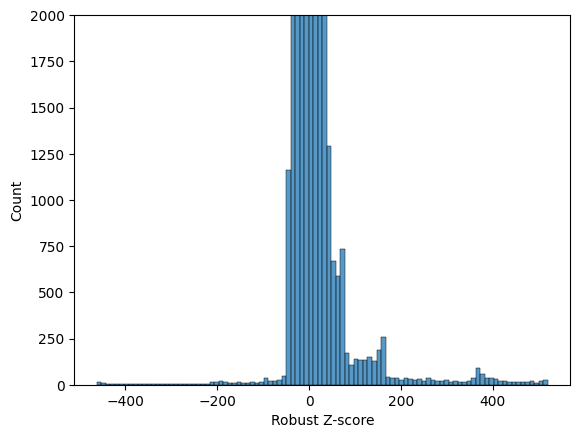

-461.76193 520.127 0.108878 5.7678356


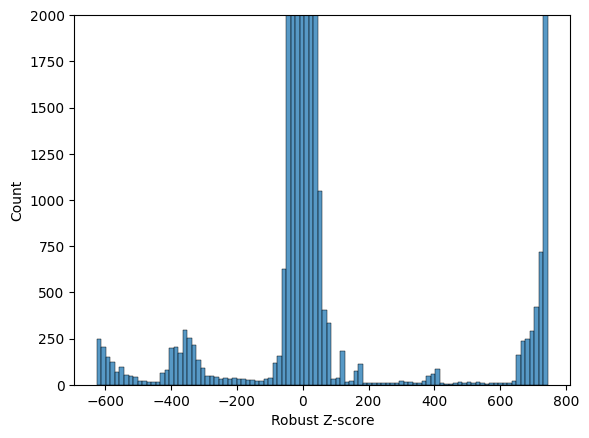

-624.8636 744.65906 0.35262826 22.71902


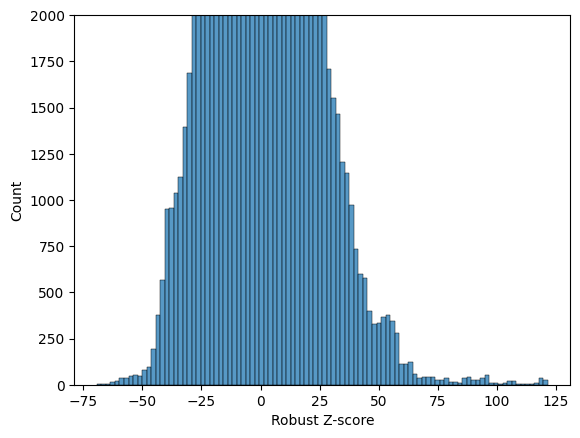

-69.25333 121.666664 0.013805165 4.696752


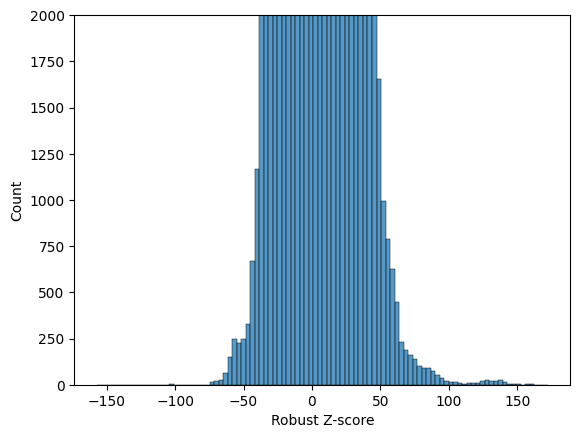

-157.18866 172.46152 0.09495603 3.6011133


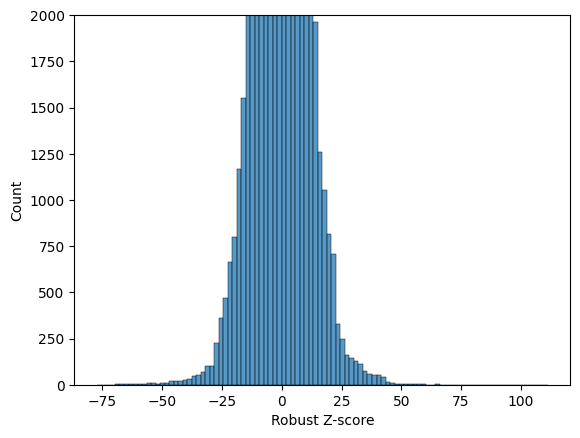

-77.3 111.28334 -0.045653906 2.293814


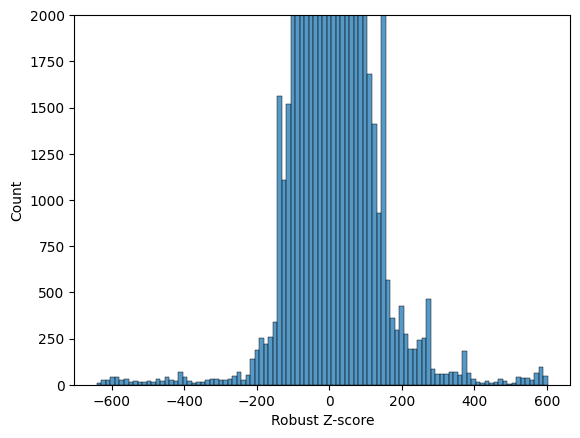

-640.6863 603.00006 0.025665026 7.6717234


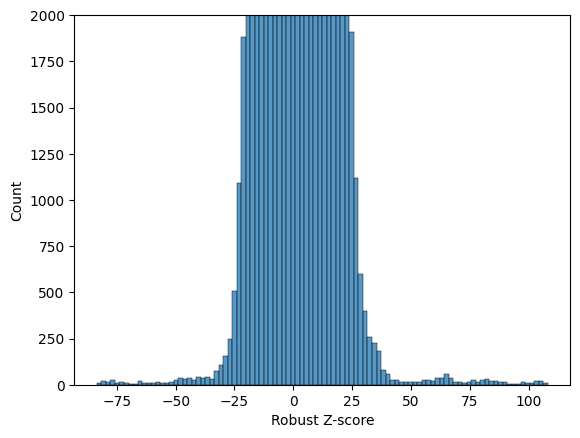

-83.40741 108.11112 0.078503475 2.4184113


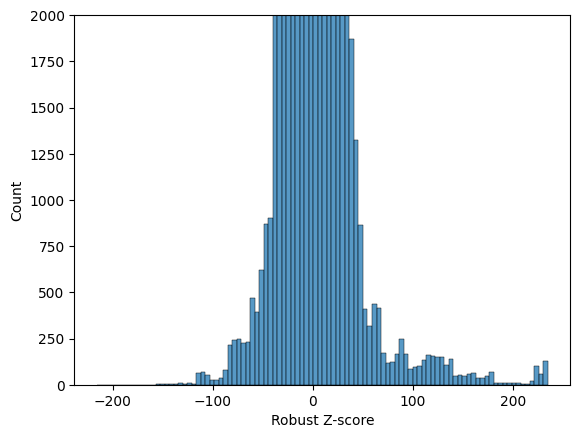

-215.73383 235.15106 -0.017898383 5.5093155


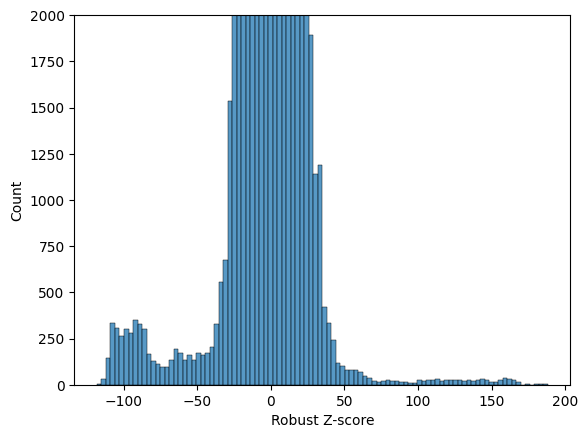

-118.3125 188.3125 -0.005756015 4.0761395


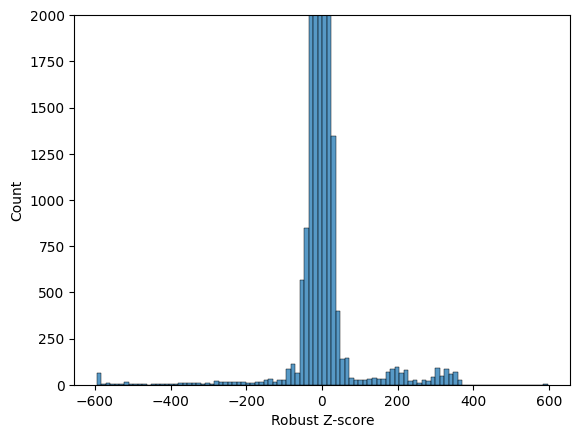

-594.39996 597.1454 -0.09334811 5.2736015


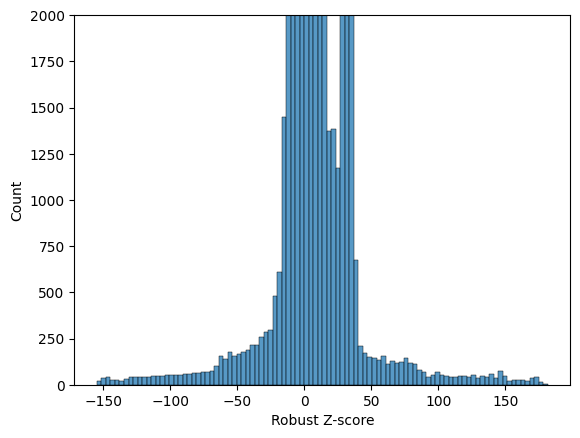

-154.79349 181.70653 0.0453148 3.217045


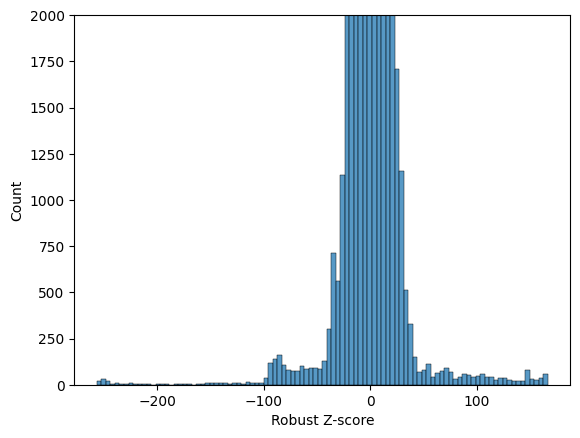

-256.55356 166.35715 0.011915609 3.313674


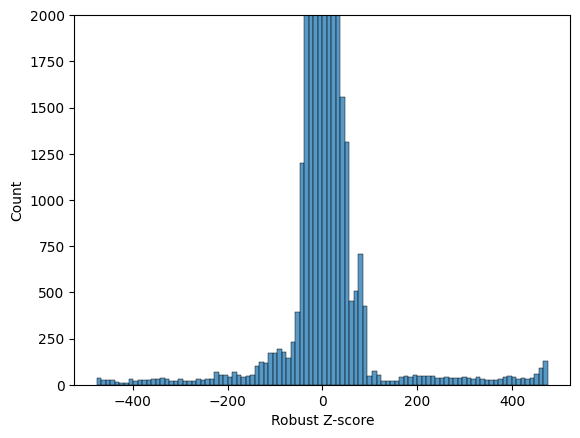

-475.058 474.72464 -0.11242922 7.3821163


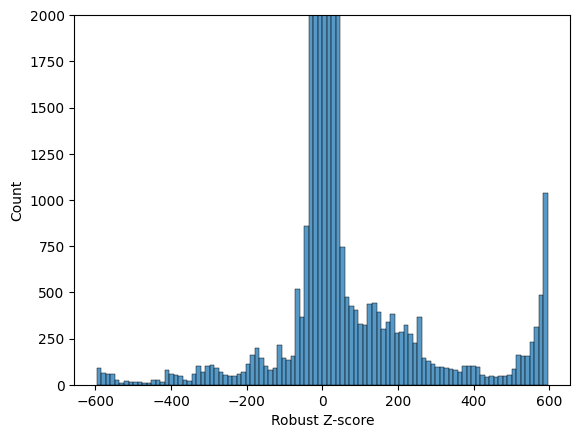

-595.8182 595.7273 0.277998 14.471296


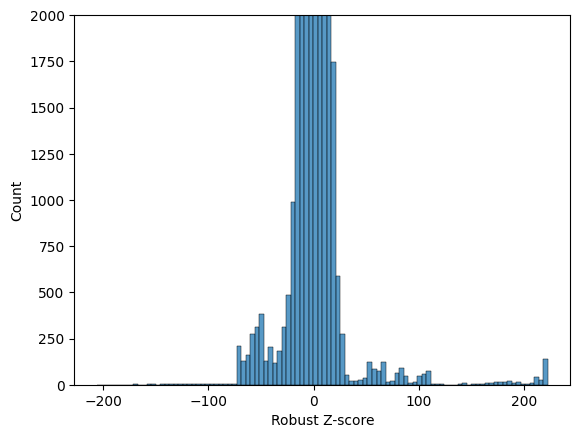

-205.85713 222.36055 0.02909396 2.3355362


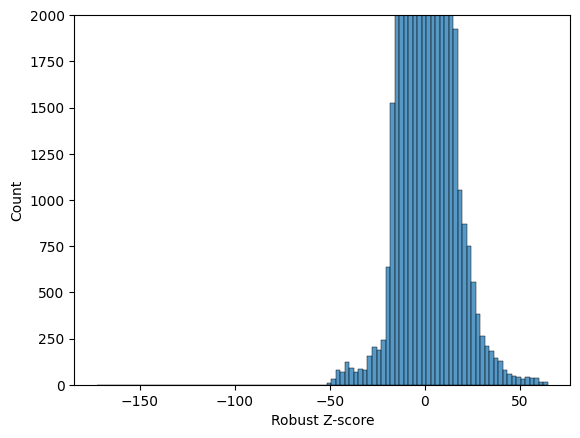

-172.5 64.75 0.018340942 2.3793986


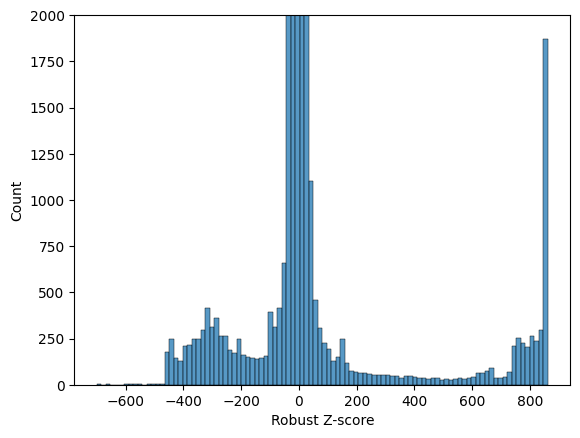

-699.3158 862.23694 0.35337973 22.756332


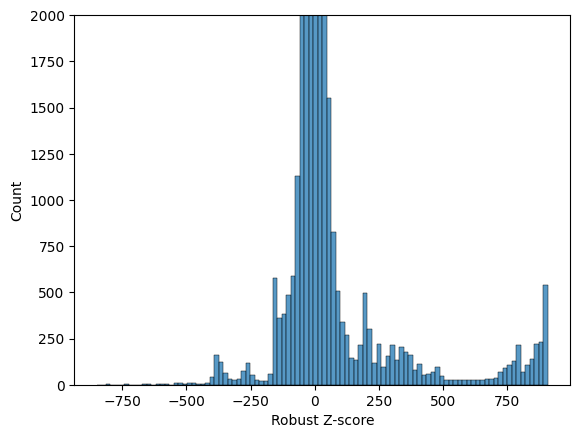

-849.25 910.1667 0.32971537 17.34403


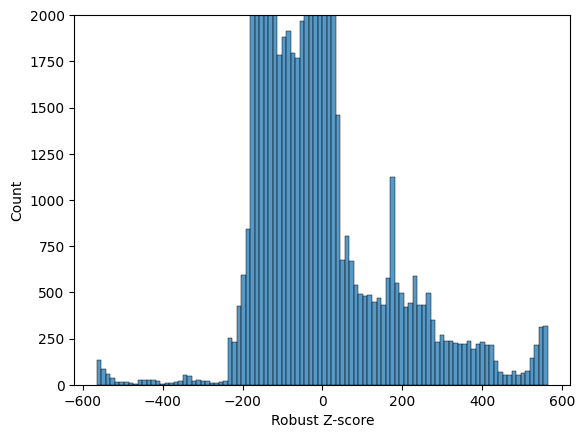

-564.9655 564.9483 -0.016233245 16.483328


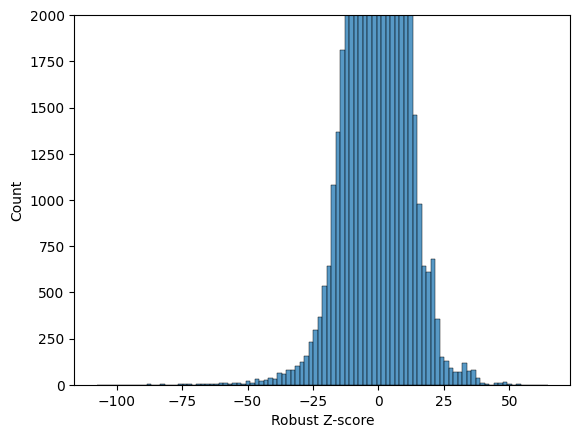

-107.54839 64.77419 0.0032356798 2.1492329


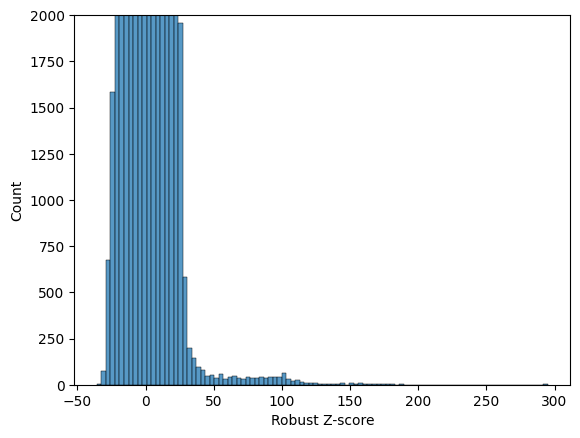

-35.711708 295.0901 -0.016439598 3.375211


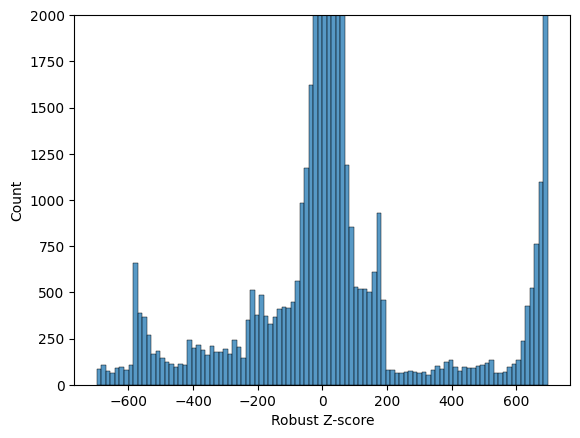

-697.2128 697.1489 0.40436128 26.69597


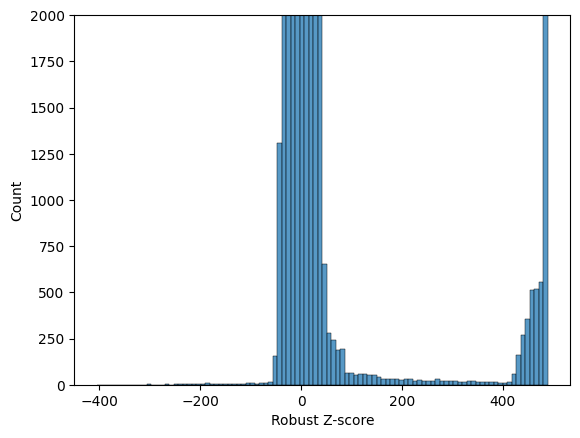

-404.52243 489.07465 0.46598327 14.854247


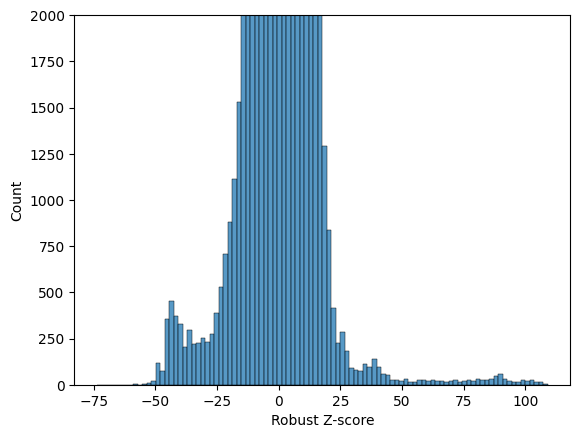

-73.676476 109.14706 -0.025318775 2.7337933


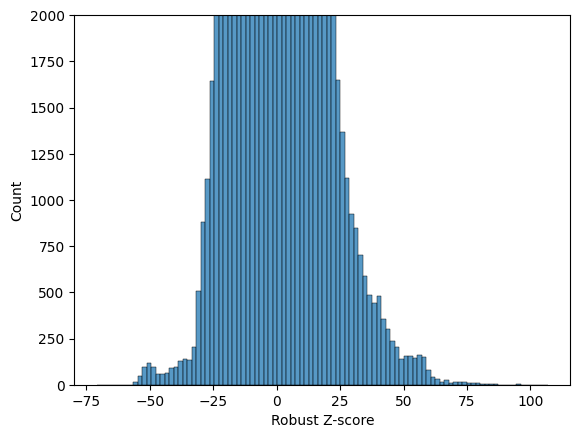

-70.83696 106.88043 -0.044416033 3.5304232


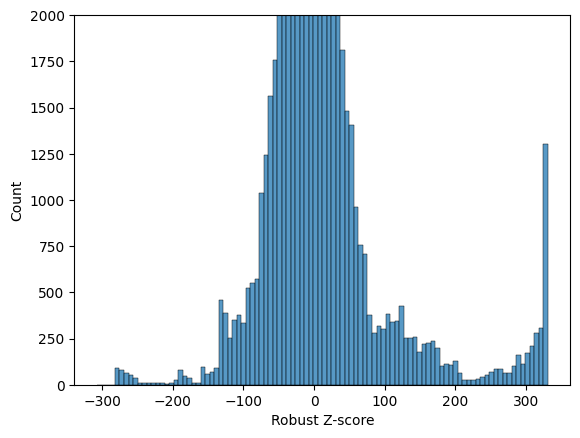

-307.303 330.9596 0.12371392 9.919811


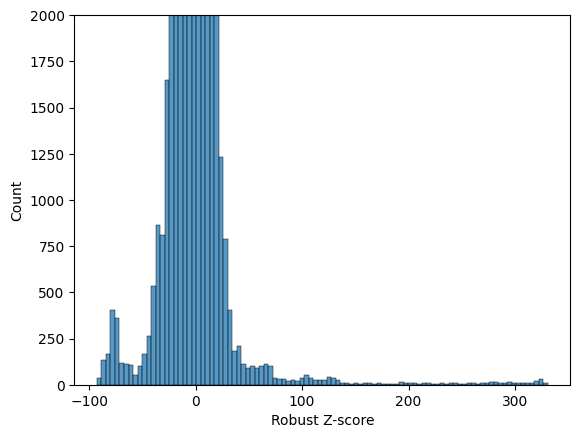

-92.61539 330.75003 -0.010462686 3.8192575


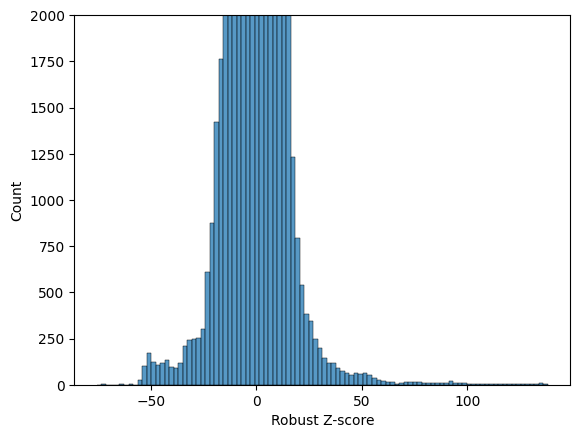

-75.465515 138.10344 0.0017779614 2.4063985


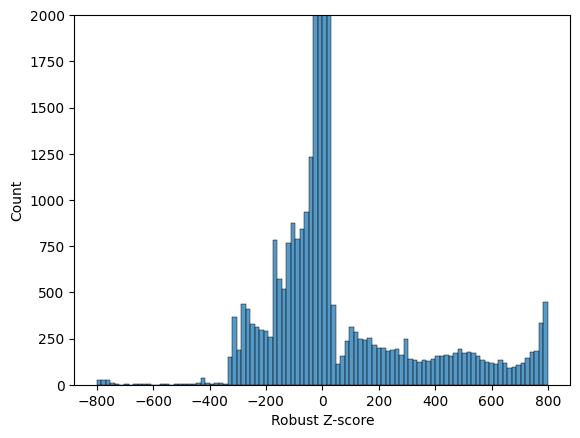

-798.95123 799.2195 0.32467613 19.75919


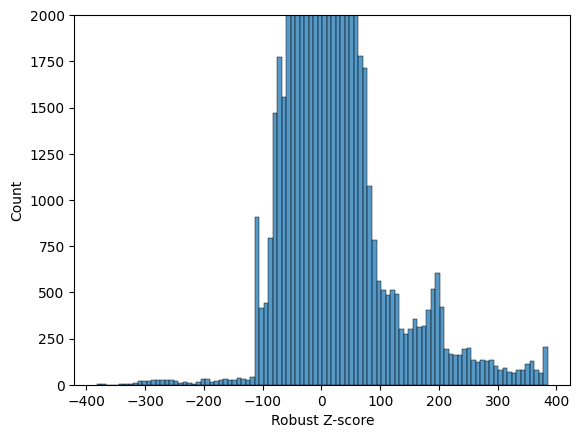

-381.97644 385.4588 0.20999427 10.419485


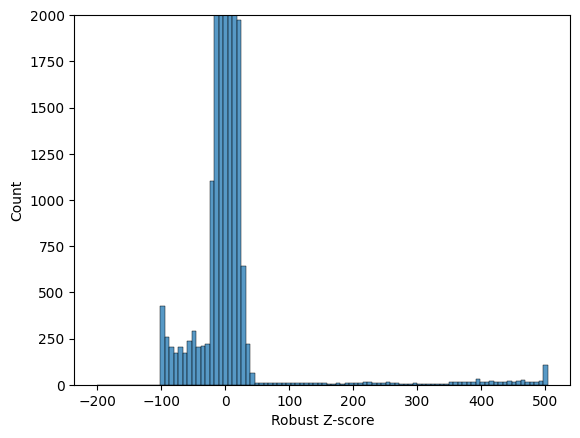

-200.49231 504.1385 0.048050348 5.0567484


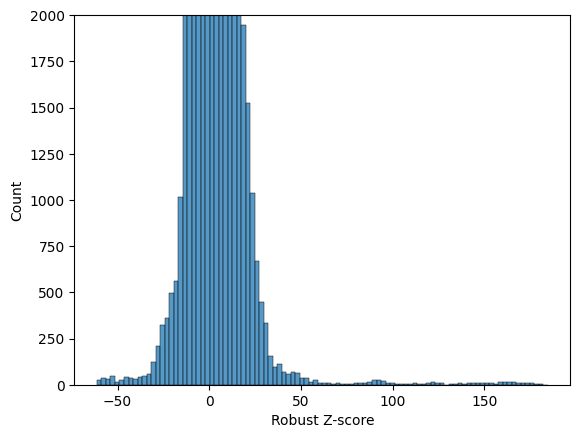

-61.22535 184.71829 0.15002431 2.3984053


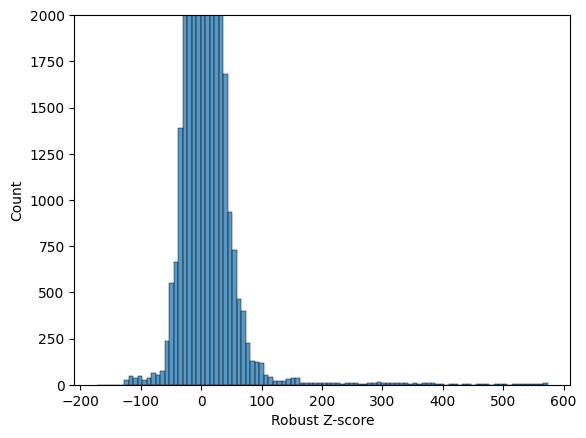

-172.65178 573.88 0.0067674117 2.8536408


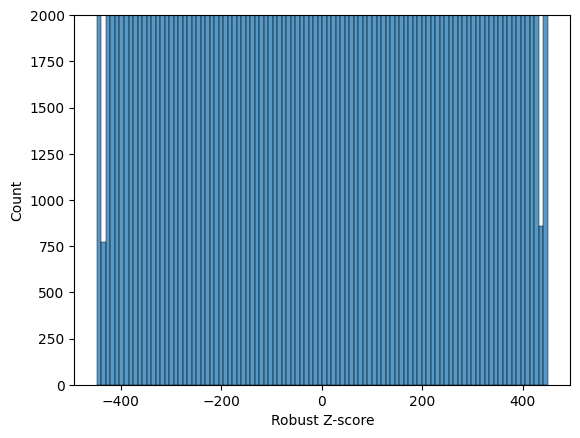

-447.65753 450.0822 0.078180775 16.758644


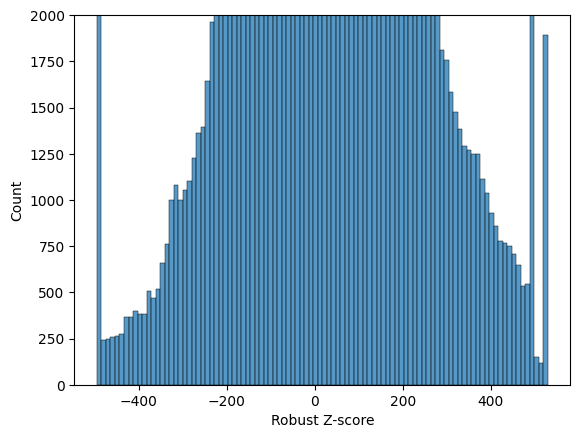

-494.96967 529.9355 0.022505991 11.983987


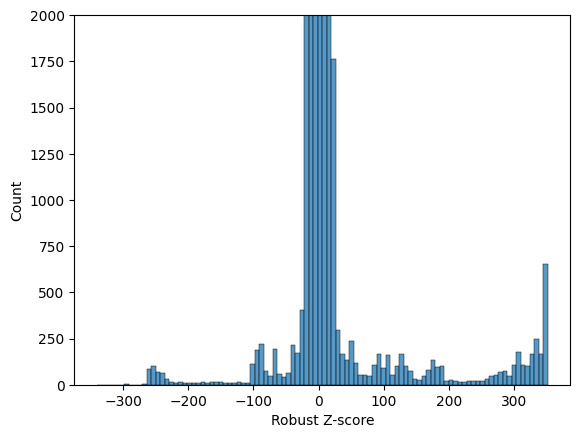

-340.39786 352.31186 0.1122071 7.0344963


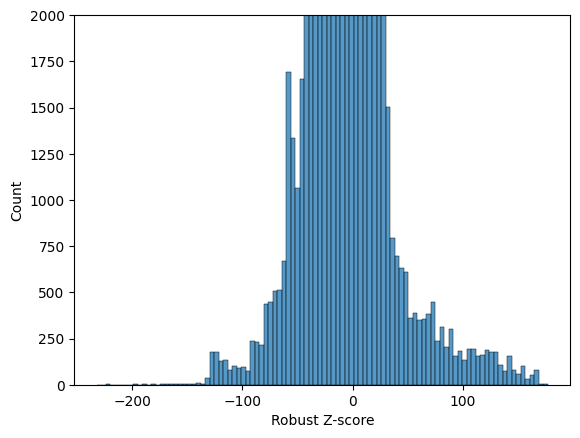

-232.02437 177.31708 -0.04123031 5.407932


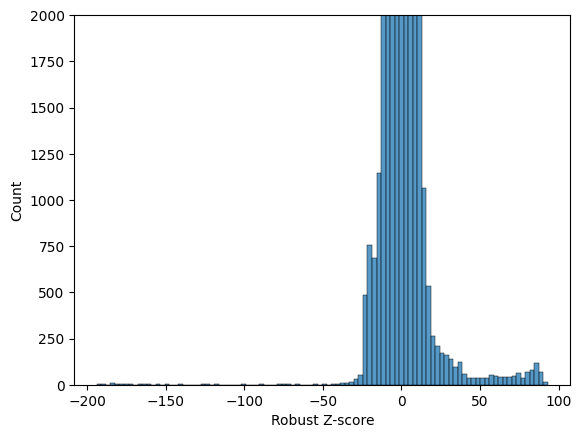

-193.92159 93.21569 -0.013370226 2.1270797


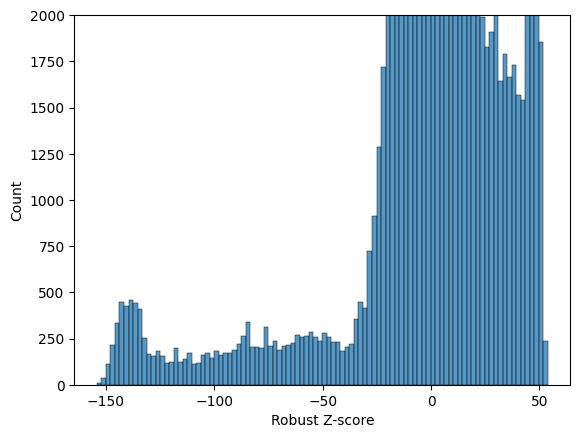

-154.17859 53.928574 0.013669474 5.414258


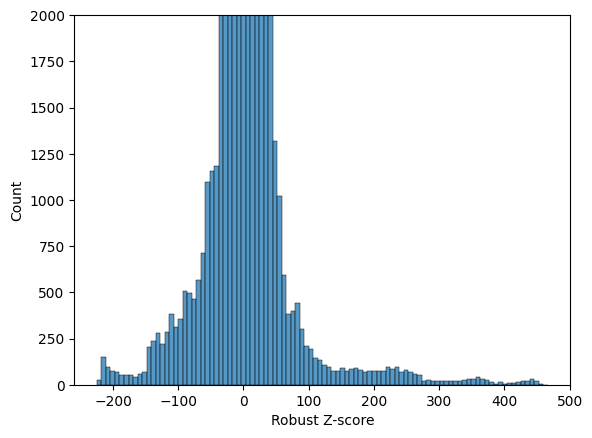

-224.65854 466.65854 0.035991117 7.401379


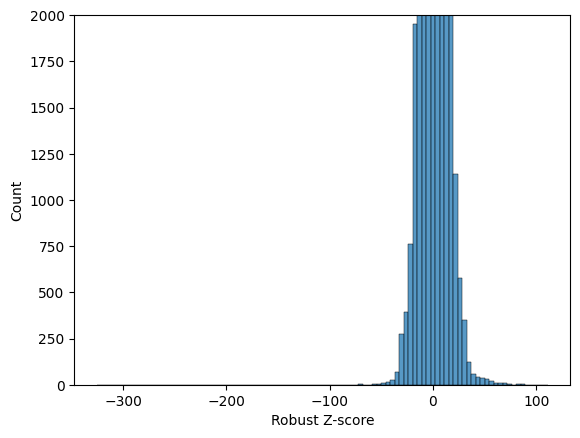

-325.25 111.350006 -0.006815036 2.1639135


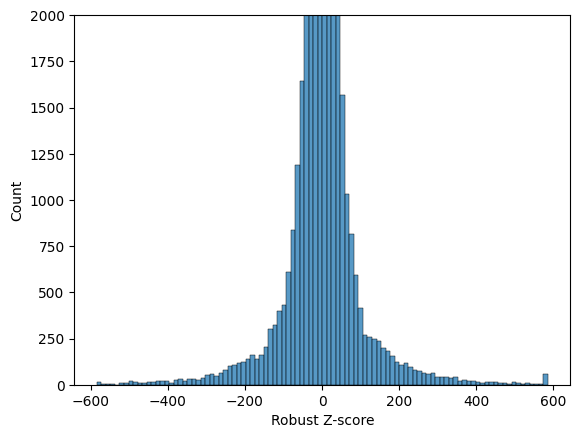

-584.125 586.1428 -0.03156684 10.422452


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# For Sjoerd, shows distribution of z-scores in data, lower than ~-5, 5 occurs very rarely
index_map = {'path': [], 'participant': [], 'session': [], 'n_samples': []}
for participant in file['participants']:
    for session in file[f'participants/{participant}/sessions']:
        # print(participant, session)
        for dataset in file[f'participants/{participant}/sessions/{session}']:
            ds = file[f'participants/{participant}/sessions/{session}/{dataset}']
            # print(ds.shape, ds.chunks)
            first_sample = ds[1,:]
            # print(first_sample.shape)
            data = ds[:].flatten()
            if data.min() < -100 or data.max() > 100:
                sns.histplot(data, bins=100, stat='count')
                plt.ylim(0, 2000)
                plt.xlabel("Robust Z-score")
                plt.show()
                print(data.min(), data.max(), data.mean(), data.std())

### Pre-train

In [9]:
model = Seq2SeqTransformer(d_model=19, ff_dim=512, num_heads=8, num_layers=6, num_classes=0, emb_dim=128)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [13]:
%load_ext line_profiler

In [15]:
import random
def random_samples():
    for idx in random.sample(range(len(train_data)), 32):
        train_data.__getitem__(idx)
%lprun -f train_data.__getitem__ random_samples()
# 30.7494s
# 5.20681s after chunking

Timer unit: 1e-09 s

Total time: 5.20681 s
File: /workspace/hmp-ai/src/hmpai/pytorch/generators.py
Function: __getitem__ at line 209

Line #      Hits         Time  Per Hit   % Time  Line Contents
   209                                               def __getitem__(self, idx):
   210        32    7033860.0 219808.1      0.1          info_idx = self._find_file_idx(idx)
   211        32   13840614.0 432519.2      0.3          info_row = self.index_map.iloc[info_idx]
   212        32    1274335.0  39823.0      0.0          file_path = info_row['path']
   213                                           
   214        32  525046617.0    2e+07     10.1          file = self._get_dataset(file_path)
   215                                           
   216        32    1835132.0  57347.9      0.0          sample_idx = idx if info_idx == 0 else idx - self.cumulative_sizes[info_idx]
   217        32 4657367460.0    1e+08     89.4          data = file[f'participants/{info_row["participant"]}/sessions

In [17]:
def subsequent_samples():
    for idx in range(1000000, 1000000+32):
        train_data.__getitem__(idx)
%lprun -f train_data.__getitem__ subsequent_samples()
# 0.419811s
# 1.13611s after chunking

Timer unit: 1e-09 s

Total time: 1.13611 s
File: /workspace/hmp-ai/src/hmpai/pytorch/generators.py
Function: __getitem__ at line 209

Line #      Hits         Time  Per Hit   % Time  Line Contents
   209                                               def __getitem__(self, idx):
   210        32    3911967.0 122249.0      0.3          info_idx = self._find_file_idx(idx)
   211        32    8029890.0 250934.1      0.7          info_row = self.index_map.iloc[info_idx]
   212        32     793383.0  24793.2      0.1          file_path = info_row['path']
   213                                           
   214        32      67999.0   2125.0      0.0          file = self._get_dataset(file_path)
   215                                           
   216        32     360236.0  11257.4      0.0          sample_idx = idx if info_idx == 0 else idx - self.cumulative_sizes[info_idx]
   217        32 1122751157.0    4e+07     98.8          data = file[f'participants/{info_row["participant"]}/sessions

In [13]:
pretrain(model, train_data, val_data, batch_size=128, workers=14, pretrain_fn=random_masking)
# ~2 batch/s with 8 workers, converges to same with 14

  0%|          | 0/937050 [00:00<?, ? batch/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(F

KeyboardInterrupt: 